In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
data_path = "../logs"
exps = os.listdir(data_path)
results = {}
intrinsic_results = {}

for exp in exps:
    try:
        nested_ = os.listdir(os.path.join(data_path, exp))
        file = os.path.join(data_path, exp, nested_[0], "train.log")
        data = pd.read_csv(file)

        # take all but last _s1, or _s2, or _s3 which are the seeds
        exp_name = "_".join(exp.split("_")[:-1])
        if exp_name not in results:
            results[exp_name] = []
            intrinsic_results[exp_name] = []
        
        results[exp_name].append(data["episode_reward"])
        intrinsic_results[exp_name].append(data["intrinsic_episode_reward"])
    except:
        print(f"Error with {exp}")
        continue

Error with PPO_SuperMarioBros-1-1-v3_ngu_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False_s0


In [27]:
# lets get the mean performance of the extrinsic agent. for the key that contains "extrinsic" compute mean and pop key 
extrinsic_performance = []
keys_to_pop = []
for key in results.keys():
    if "extrinsic" in key:
        # compute the mean for the last 100 episodes
        mean = np.mean([np.mean(x[-100:]) for x in results[key]])
        extrinsic_performance.append(mean)
        keys_to_pop.append(key)

# for key in keys_to_pop:
#    results.pop(key)

# plot the extrinsic curve
print(extrinsic_performance)

[]


In [28]:
# make sure for each key in results, all the lists of rewards in the key are of the same length (which should be the max length common to all)
min_lens = {}
for key in results:
    min_len = min([len(x) for x in results[key]])
    results[key] = [x[:min_len] for x in results[key]]
    min_lens[key] = min_len
    print(f"Key {key} has {len(results[key])} runs of length {min_len}")

min_lens_intrinsic = {}
for key in intrinsic_results:
    min_len = min([len(x) for x in intrinsic_results[key]])
    intrinsic_results[key] = [x[:min_len] for x in intrinsic_results[key]]
    min_lens_intrinsic[key] = min_len
    print(f"Key {key} has {len(intrinsic_results[key])} runs of length {min_len}")

Key PPO_SuperMarioBros-1-1-v3_ride_obsRMS:False_rewNorm:minmax_updateProp:1.0_rff:False has 1 runs of length 183
Key PPO_SuperMarioBros-1-1-v3_ride_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False has 1 runs of length 155
Key PPO_SuperMarioBros-1-1-v3_ngu_obsRMS:False_rewNorm:minmax_updateProp:1.0_rff:False has 1 runs of length 27
Key PPO_SuperMarioBros-1-1-v3_ride_obsRMS:False_rewNorm:minmax_updateProp:1.0_rff:False has 1 runs of length 183
Key PPO_SuperMarioBros-1-1-v3_ride_obsRMS:False_rewNorm:rms_updateProp:1.0_rff:False has 1 runs of length 155
Key PPO_SuperMarioBros-1-1-v3_ngu_obsRMS:False_rewNorm:minmax_updateProp:1.0_rff:False has 1 runs of length 27


In [29]:
# # make a function to plot cut the reward to early stop. 
# # When the running mean of the next X episodes will be less than the current running mean of the last X episiodes, we stop
# # then we append the necessary number of current_running_mean to the list until its of size min_lens[key]

# def cut_with_early_stop(rewards, window=40):
#     running_mean = [np.mean(rewards[:window])]
#     for i in range(window, len(rewards)):
#         running_mean.append(np.mean(rewards[i-window:i]))
#         if running_mean[-1] < running_mean[-2]:
#             break
#     return running_mean + [running_mean[-1]] * (len(rewards) - len(running_mean))


# # overwrite the results with the cutted rewards
# for key in results:
#     results[key] = [cut_with_early_stop(x, window=30) for x in results[key]]

In [30]:
# len(results["ppo_SuperMarioBros-1-1-v3_rnd_obsRMS:False_rewNorm:rms_updateProp:1.0"][2])

/home/roger/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/roger/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


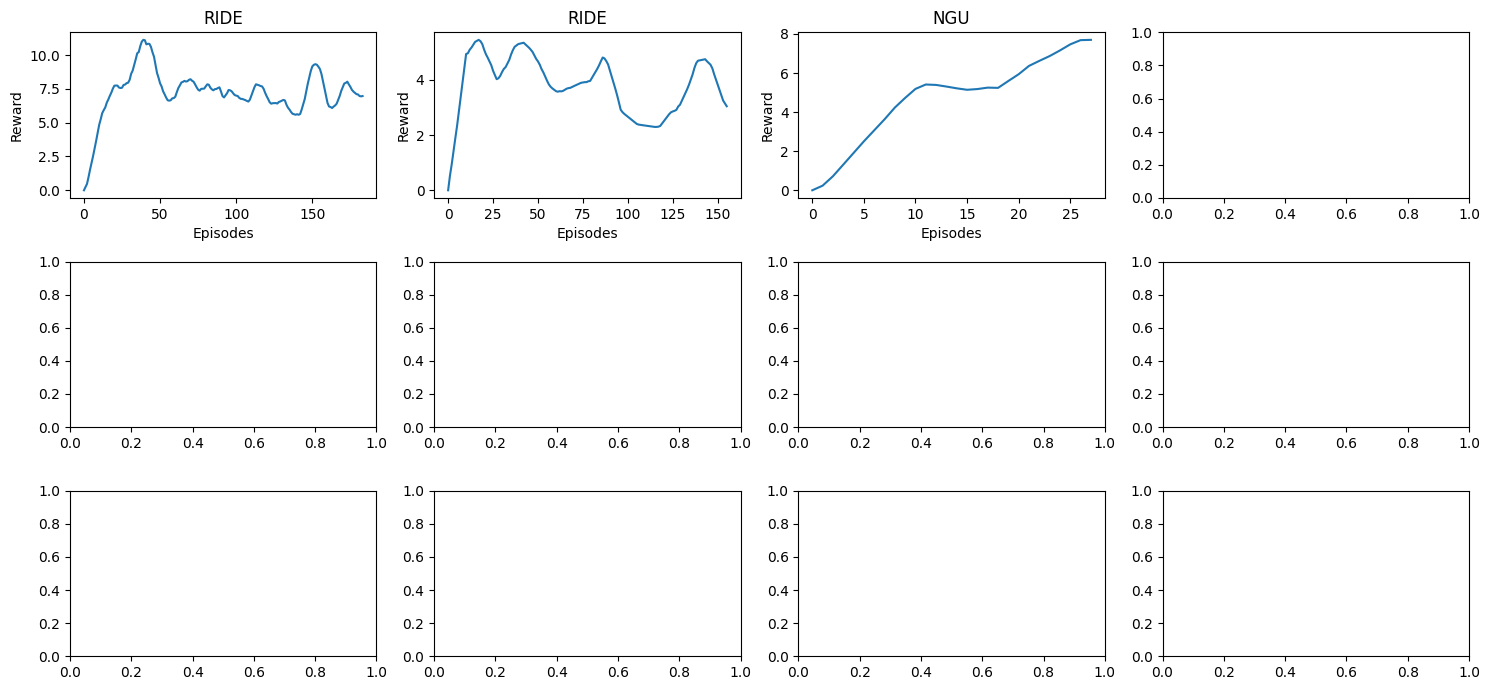

In [31]:
# plot 11 subplots
fig, axs = plt.subplots(3, 4, figsize=(15, 7))
axs = axs.ravel()

for i, key in enumerate(results):
    try:
        mean = np.mean(results[key], axis=0)
        std = np.std(results[key], axis=0)
        
        # append 0s to the beginning so that they start in the same place
        mean = np.append(np.zeros(10), mean)
        std = np.append(np.zeros(10), std)

        # smooth with np.convolve
        window = 10
        mean = np.convolve(mean, np.ones(window), 'valid') / window
        std = np.convolve(std, np.ones(window), 'valid') / window
        
        x = np.arange(len(mean))

        # plot line at the extrinsic performance
        axs[i].axhline(y=np.mean(extrinsic_performance), color="r", linestyle="--")

        algo_name = key.split("_")[2]

        axs[i].fill_between(x, mean - std, mean + std, alpha=0.3)
        axs[i].plot(x, mean)
        # y limit from 0 to 3500
        axs[i].set_ylim([-1000, 3500])
        axs[i].set_title(algo_name.upper())
        axs[i].set_xlabel("Episodes")
        axs[i].set_ylabel("Reward")
    except:
        print(f"Error with {key}")
        continue
plt.tight_layout()

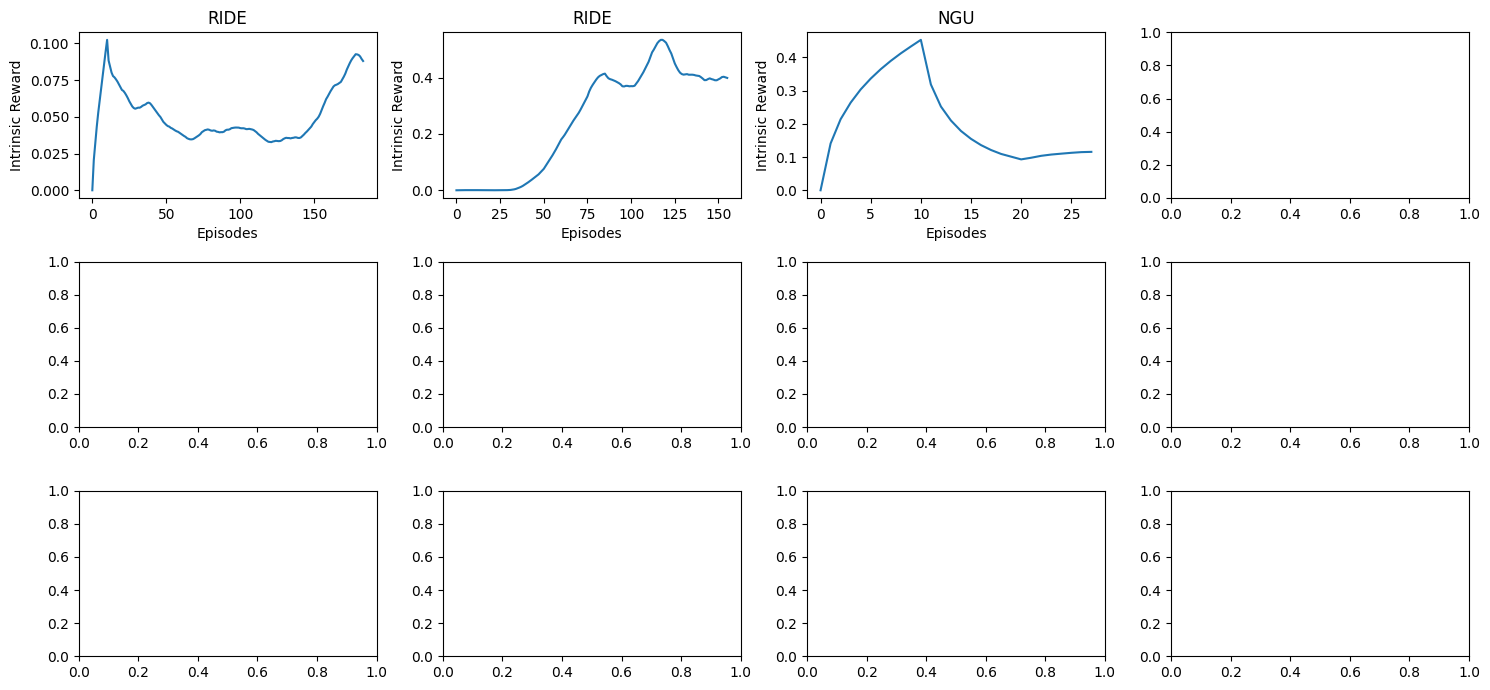

In [32]:
# make the same plot as above for intrinsic rewards
fig, axs = plt.subplots(3, 4, figsize=(15, 7))
axs = axs.ravel()

for i, key in enumerate(intrinsic_results):
    try:
        mean = np.mean(intrinsic_results[key], axis=0)
        std = np.std(intrinsic_results[key], axis=0)
        
        # append 0s to the beginning so that they start in the same place
        mean = np.append(np.zeros(10), mean)
        std = np.append(np.zeros(10), std)

        # smooth with np.convolve
        window = 10
        mean = np.convolve(mean, np.ones(window), 'valid') / window
        std = np.convolve(std, np.ones(window), 'valid') / window
        
        x = np.arange(len(mean))

        # plot line at the extrinsic performance
        #axs[i].axhline(y=np.mean(extrinsic_performance), color="r", linestyle="--")

        algo_name = key.split("_")[2]

        axs[i].fill_between(x, mean - std, mean + std, alpha=0.3)
        axs[i].plot(x, mean)
        # y limit from 0 to 3500
        #axs[i].set_ylim([-1000, 3500])
        axs[i].set_title(algo_name.upper())
        axs[i].set_xlabel("Episodes")
        axs[i].set_ylabel("Intrinsic Reward")
    except:
        print(f"Error with {key}")
        continue

plt.tight_layout()